In [48]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor

# Task 1 - Regression 

## Load settings

In [49]:
pd.set_option('display.max_colwidth',-1)
import sys
np.set_printoptions(threshold=sys.maxsize)

k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA

scoring='neg_mean_squared_error' # Scoring method for GridsearchCV
score_function = f_regression # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [50]:
# GridSearchCV
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[SVR()],
        'clf__C':[0.1,10,100],
    },{
        'clf':[Lasso(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],

    },{
        'clf':[ElasticNet(random_state=seed)],
        'clf__alpha':[0.1,1.0,2.0,5.0],
        'clf__max_iter':[100,5000,10000],
    },{
        'clf':[MLPRegressor()],
        'clf__hidden_layer_sizes':[(100,),(50,50,50)],
        'clf__activation':['relu'],
        'clf__solver':['adam'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,100,50,2000],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [51]:
filename = "datasets/cnDieselTrain.mat"

mat = loadmat(filename)
input_train = mat['cnTrainX'].T

target_train = mat['cnTrainY'].reshape(len(input_train))
input_test = mat['cnTestX'].T

## Data info

In [52]:
get_data_info(input_train, target_train)

Length of 133
X.shape: (133, 401) y.shape: (133,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False
Input: [[ 6.19124336e-03  5.55355105e-03  4.91585874e-03  4.27816643e-03
   3.64047413e-03  3.00278182e-03  2.45272727e-03  1.86373636e-03
   1.28050909e-03  7.44918182e-04  2.76654545e-04 -1.01172727e-04
  -4.35000000e-04 -8.08572727e-04 -1.31120909e-03 -1.89720909e-03
  -2.44825455e-03 -2.96350000e-03 -3.35212727e-03 -3.56997273e-03
  -3.60011818e-03 -3.47154545e-03 -3.21996364e-03 -2.88049091e-03
  -2.50783636e-03 -2.15782727e-03 -1.86320909e-03 -1.60376364e-03
  -1.38455455e-03 -1.19356364e-03 -1.02395455e-03 -8.69800000e-04
  -7.23400000e-04 -6.00345455e-04 -4.81090909e-04 -3.71918182e-04
  -2.65954545e-04 -1.59854545e-04 -5.21909091e-05  6.44181818e-05
   1.85345455e-04  3.09290909e-04  4.37972727e-04  5.68472727e-04
   6.93781818e-04  8.01936364e-04  8.82318182e-04  9.40445455e-04
   1.00050000e-03  1.06649091e-03  1.13572727e-03  1.20810000e-03
   1.

## Preprocess
Normalize the dataset

In [53]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

133


## Feature reduction
Reduce dimensionality by PCA transform

In [54]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (133, 401)
transformed shape: (133, 7)
Explained variance: [0.44006606 0.20850319 0.15866727 0.08548419 0.04025895 0.01514767
 0.00792292]


# Plot PCA

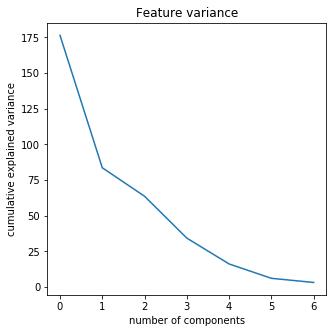

In [55]:
plot_feature_variance(pca_input)

## Plot top 10 histogram over reduced features

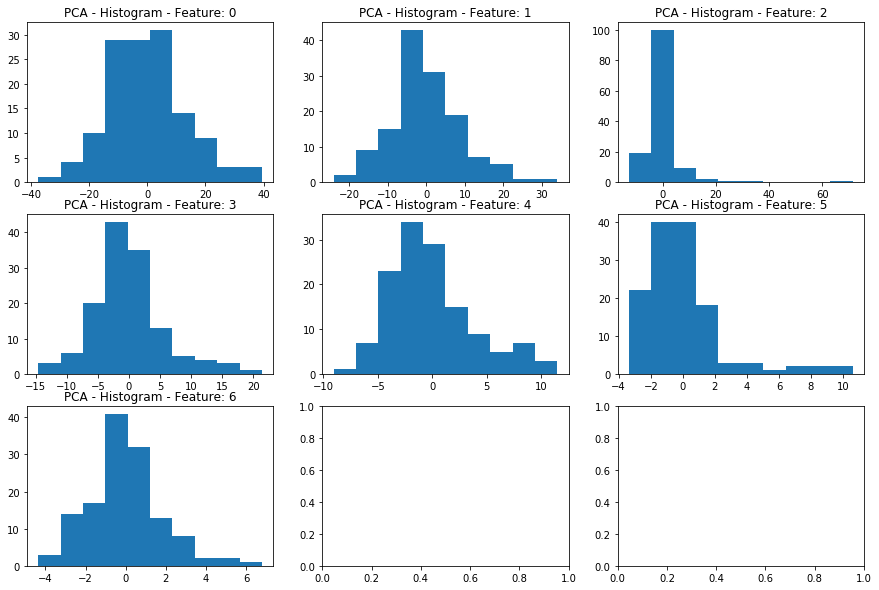

In [56]:
plot_top_features(feature_tot,pca_input)

# Feature selection
Extract top features above depending on PCA

(133, 401)


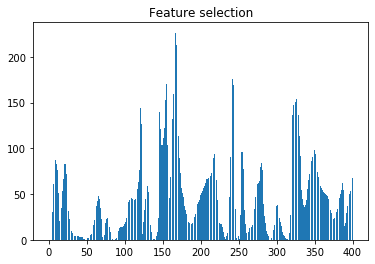

In [57]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, feature_tot=feature_tot)

## Hyperparameter tuning

In [58]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 67 candidates, totalling 670 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 481 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 670 out of 670 | elapsed: 13.9min finished


## Get Model info

In [59]:
get_model_info(grid)

Best score: -4.908993087999625
Best params {'clf': ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=5000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False), 'clf__alpha': 0.1, 'clf__max_iter': 5000}

                                                                                                                                                                                                                                  clf  \
9   ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n           max_iter=5000, normalize=False, positive=False, precompute=False,\n           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)   
8   ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n           max_iter=5000, normalize=False, positive=False, precompute=False,\n           random_state=42, selection='cyclic', tol=0.0001, war

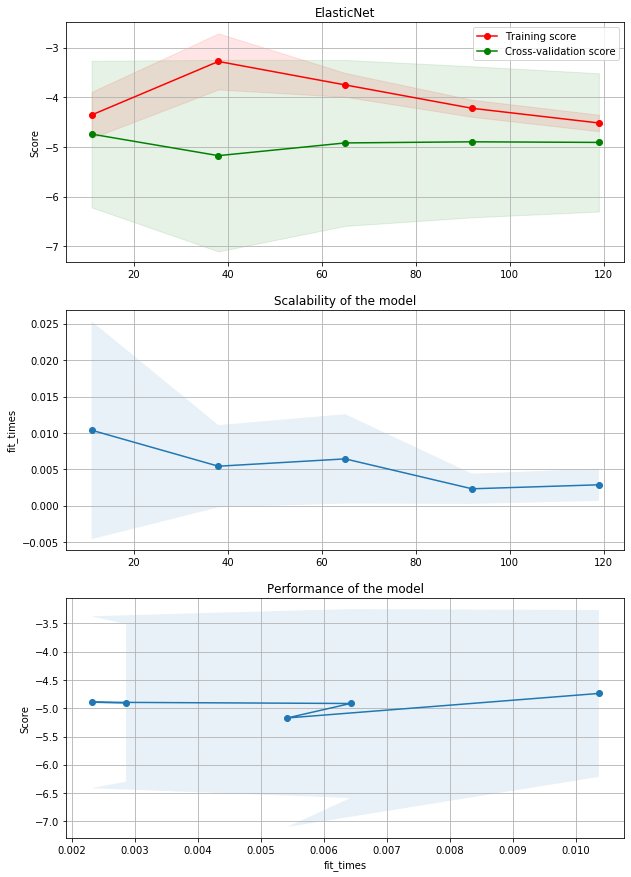

In [60]:
validate_curve(grid, input_train_fs, target_train,scoring=scoring, k=k)

# Predict testset

In [61]:
model = predict_model(grid, input_train_fs, target_train, input_test_fs)

[49.80839109 48.31626423 47.7240841  48.79779241 49.32478612 49.5632713
 51.43151285 48.26818754 52.82940486 53.69245789 48.88093308 53.16619692
 52.98108912 48.24416495 46.6059743  51.14407191 59.02349186 47.81136857
 49.24498097 46.21095806 49.76510706 47.70049171 43.7729782  49.81414554
 46.09856706 49.77250418 50.37676037 44.71325996 46.99521295 50.40544676
 49.91020982 47.3477196  47.39899864 49.97092624 50.98829958 47.66799938
 49.37139829 49.96258446 45.26677239 46.10850057 46.12909505 48.73852269
 48.91667255 47.21477971 46.92888215 52.19688962 48.07887259 45.14953753
 46.84207372 43.07631747 47.15134273 49.57506569 46.57427347 47.91314251
 46.76807307 47.93700816 46.38314315 47.84570432 50.00650078 49.09051146
 46.77692973 48.40917942 47.67432276 46.67395326 47.51321552 47.74744518
 50.87301452 52.44744729 52.92507224 51.3120265  49.81775473 48.94365935
 46.6672423  45.1339575  48.6800628  46.70715558 47.79555325 46.4123463
 50.41905026 48.62462409 49.04522966 48.24813168 46.1